<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[11:03:53] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


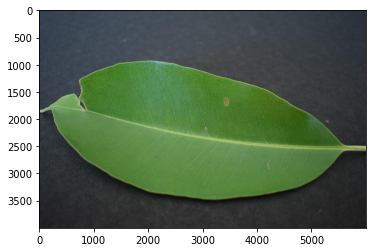

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

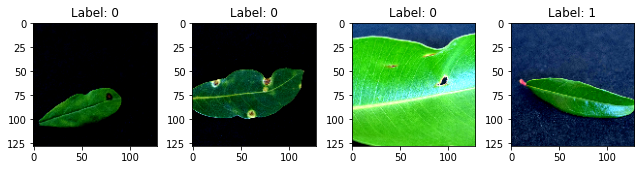

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[11:03:59] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[11:04:01] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2507817564903831 samples/sec                   batch loss = 0.49925222992897034 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2678753231427002 samples/sec                   batch loss = 1.6684740781784058 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2630877758287096 samples/sec                   batch loss = 0.7400662302970886 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.2606039039221355 samples/sec                   batch loss = 1.2462621927261353 | accuracy = 0.45


Epoch[1] Batch[25] Speed: 1.2685693070972655 samples/sec                   batch loss = 0.23392514884471893 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.2639021038045246 samples/sec                   batch loss = 0.9211083650588989 | accuracy = 0.5083333333333333


Epoch[1] Batch[35] Speed: 1.2669463120571607 samples/sec                   batch loss = 0.5565630197525024 | accuracy = 0.5285714285714286


Epoch[1] Batch[40] Speed: 1.2641141839742043 samples/sec                   batch loss = 0.6269106864929199 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.2664386749102003 samples/sec                   batch loss = 1.4518678188323975 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.266790859953947 samples/sec                   batch loss = 0.5366885662078857 | accuracy = 0.555


Epoch[1] Batch[55] Speed: 1.2652977864927033 samples/sec                   batch loss = 0.5136560797691345 | accuracy = 0.5590909090909091


Epoch[1] Batch[60] Speed: 1.2662065101361633 samples/sec                   batch loss = 0.5676737427711487 | accuracy = 0.5708333333333333


Epoch[1] Batch[65] Speed: 1.2676772088218378 samples/sec                   batch loss = 0.3568505048751831 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.2660474179477588 samples/sec                   batch loss = 0.5930758714675903 | accuracy = 0.5714285714285714


Epoch[1] Batch[75] Speed: 1.2663500618410473 samples/sec                   batch loss = 0.6485515236854553 | accuracy = 0.57


Epoch[1] Batch[80] Speed: 1.256050312039548 samples/sec                   batch loss = 0.8829212188720703 | accuracy = 0.571875


Epoch[1] Batch[85] Speed: 1.2638367894484208 samples/sec                   batch loss = 0.6444948315620422 | accuracy = 0.5794117647058824


Epoch[1] Batch[90] Speed: 1.264155141643908 samples/sec                   batch loss = 0.5545245409011841 | accuracy = 0.5861111111111111


Epoch[1] Batch[95] Speed: 1.2602057360593648 samples/sec                   batch loss = 1.4397221803665161 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.2675519344329673 samples/sec                   batch loss = 0.6539841890335083 | accuracy = 0.605


Epoch[1] Batch[105] Speed: 1.2694571867323494 samples/sec                   batch loss = 0.604448139667511 | accuracy = 0.6


Epoch[1] Batch[110] Speed: 1.2667657998627921 samples/sec                   batch loss = 0.5403258204460144 | accuracy = 0.5931818181818181


Epoch[1] Batch[115] Speed: 1.2632722826103326 samples/sec                   batch loss = 0.8899280428886414 | accuracy = 0.5956521739130435


Epoch[1] Batch[120] Speed: 1.2625951026209368 samples/sec                   batch loss = 0.46708008646965027 | accuracy = 0.6020833333333333


Epoch[1] Batch[125] Speed: 1.2668935018948788 samples/sec                   batch loss = 0.4182243347167969 | accuracy = 0.608


Epoch[1] Batch[130] Speed: 1.2673052890600263 samples/sec                   batch loss = 0.6658807396888733 | accuracy = 0.6019230769230769


Epoch[1] Batch[135] Speed: 1.2719991532750998 samples/sec                   batch loss = 0.871863842010498 | accuracy = 0.5944444444444444


Epoch[1] Batch[140] Speed: 1.270161654512453 samples/sec                   batch loss = 0.5988268852233887 | accuracy = 0.5964285714285714


Epoch[1] Batch[145] Speed: 1.2743321425693235 samples/sec                   batch loss = 0.4668537676334381 | accuracy = 0.5982758620689655


Epoch[1] Batch[150] Speed: 1.2649205855428005 samples/sec                   batch loss = 1.0200152397155762 | accuracy = 0.6


Epoch[1] Batch[155] Speed: 1.2738487465883015 samples/sec                   batch loss = 0.46677255630493164 | accuracy = 0.6048387096774194


Epoch[1] Batch[160] Speed: 1.26715137585022 samples/sec                   batch loss = 0.6681771278381348 | accuracy = 0.603125


Epoch[1] Batch[165] Speed: 1.2648126371980248 samples/sec                   batch loss = 0.5922774076461792 | accuracy = 0.6090909090909091


Epoch[1] Batch[170] Speed: 1.2696491319811924 samples/sec                   batch loss = 0.48410001397132874 | accuracy = 0.611764705882353


Epoch[1] Batch[175] Speed: 1.2676768256819844 samples/sec                   batch loss = 0.3477647602558136 | accuracy = 0.6157142857142858


Epoch[1] Batch[180] Speed: 1.2673431030628939 samples/sec                   batch loss = 0.9529314041137695 | accuracy = 0.6166666666666667


Epoch[1] Batch[185] Speed: 1.269733114269287 samples/sec                   batch loss = 0.4413570463657379 | accuracy = 0.6189189189189189


Epoch[1] Batch[190] Speed: 1.269423376565204 samples/sec                   batch loss = 0.43207794427871704 | accuracy = 0.6223684210526316


Epoch[1] Batch[195] Speed: 1.2715907678408473 samples/sec                   batch loss = 0.7101858258247375 | accuracy = 0.6294871794871795


Epoch[1] Batch[200] Speed: 1.2650354200833192 samples/sec                   batch loss = 0.21911318600177765 | accuracy = 0.63375


Epoch[1] Batch[205] Speed: 1.274555968027495 samples/sec                   batch loss = 0.7807202935218811 | accuracy = 0.6317073170731707


Epoch[1] Batch[210] Speed: 1.261893780554104 samples/sec                   batch loss = 0.37789806723594666 | accuracy = 0.6333333333333333


Epoch[1] Batch[215] Speed: 1.2648850139556254 samples/sec                   batch loss = 1.3575023412704468 | accuracy = 0.6337209302325582


Epoch[1] Batch[220] Speed: 1.2680349709218088 samples/sec                   batch loss = 0.5433853268623352 | accuracy = 0.6295454545454545


Epoch[1] Batch[225] Speed: 1.2679288859532414 samples/sec                   batch loss = 0.6082021594047546 | accuracy = 0.63


Epoch[1] Batch[230] Speed: 1.2621168655369723 samples/sec                   batch loss = 0.6074992418289185 | accuracy = 0.6315217391304347


Epoch[1] Batch[235] Speed: 1.2648660369031244 samples/sec                   batch loss = 0.6784588098526001 | accuracy = 0.6308510638297873


Epoch[1] Batch[240] Speed: 1.2650529713846999 samples/sec                   batch loss = 0.7416240572929382 | accuracy = 0.63125


Epoch[1] Batch[245] Speed: 1.2633146126428476 samples/sec                   batch loss = 0.3501357436180115 | accuracy = 0.6326530612244898


Epoch[1] Batch[250] Speed: 1.2640881819938055 samples/sec                   batch loss = 0.608452558517456 | accuracy = 0.633


Epoch[1] Batch[255] Speed: 1.2652978819184646 samples/sec                   batch loss = 0.9713365435600281 | accuracy = 0.6303921568627451


Epoch[1] Batch[260] Speed: 1.2681596698065252 samples/sec                   batch loss = 1.5070120096206665 | accuracy = 0.6307692307692307


Epoch[1] Batch[265] Speed: 1.2668580105820586 samples/sec                   batch loss = 0.681168794631958 | accuracy = 0.630188679245283


Epoch[1] Batch[270] Speed: 1.267780186053056 samples/sec                   batch loss = 0.7664695382118225 | accuracy = 0.6305555555555555


Epoch[1] Batch[275] Speed: 1.264110088353203 samples/sec                   batch loss = 0.8950154185295105 | accuracy = 0.6309090909090909


Epoch[1] Batch[280] Speed: 1.2657705113746618 samples/sec                   batch loss = 0.20528987050056458 | accuracy = 0.6348214285714285


Epoch[1] Batch[285] Speed: 1.2622417326187068 samples/sec                   batch loss = 0.46931591629981995 | accuracy = 0.6368421052631579


Epoch[1] Batch[290] Speed: 1.2651906324461528 samples/sec                   batch loss = 0.2536250352859497 | accuracy = 0.6370689655172413


Epoch[1] Batch[295] Speed: 1.26768764947199 samples/sec                   batch loss = 0.37660831212997437 | accuracy = 0.6372881355932203


Epoch[1] Batch[300] Speed: 1.2692360125213737 samples/sec                   batch loss = 0.7036359310150146 | accuracy = 0.6366666666666667


Epoch[1] Batch[305] Speed: 1.272119327912306 samples/sec                   batch loss = 0.49592483043670654 | accuracy = 0.6368852459016393


Epoch[1] Batch[310] Speed: 1.2723937120882445 samples/sec                   batch loss = 0.39664822816848755 | accuracy = 0.6387096774193548


Epoch[1] Batch[315] Speed: 1.2689474399161842 samples/sec                   batch loss = 0.7532547116279602 | accuracy = 0.6388888888888888


Epoch[1] Batch[320] Speed: 1.274859497125049 samples/sec                   batch loss = 0.357265830039978 | accuracy = 0.6390625


Epoch[1] Batch[325] Speed: 1.2697495468860545 samples/sec                   batch loss = 0.7612283229827881 | accuracy = 0.6384615384615384


Epoch[1] Batch[330] Speed: 1.2716869596802276 samples/sec                   batch loss = 0.2403978854417801 | accuracy = 0.6393939393939394


Epoch[1] Batch[335] Speed: 1.267722133575253 samples/sec                   batch loss = 0.8030406832695007 | accuracy = 0.6395522388059701


Epoch[1] Batch[340] Speed: 1.2761002962215306 samples/sec                   batch loss = 0.8159367442131042 | accuracy = 0.638235294117647


Epoch[1] Batch[345] Speed: 1.266791912116867 samples/sec                   batch loss = 1.2349718809127808 | accuracy = 0.6384057971014493


Epoch[1] Batch[350] Speed: 1.2657588608392363 samples/sec                   batch loss = 0.6855788230895996 | accuracy = 0.64


Epoch[1] Batch[355] Speed: 1.2673040445868942 samples/sec                   batch loss = 1.0896601676940918 | accuracy = 0.6394366197183099


Epoch[1] Batch[360] Speed: 1.271381952489257 samples/sec                   batch loss = 1.2857248783111572 | accuracy = 0.6430555555555556


Epoch[1] Batch[365] Speed: 1.2711214871770822 samples/sec                   batch loss = 0.5773678421974182 | accuracy = 0.6445205479452055


Epoch[1] Batch[370] Speed: 1.2677539372445321 samples/sec                   batch loss = 0.8644256591796875 | accuracy = 0.6445945945945946


Epoch[1] Batch[375] Speed: 1.2671896592250098 samples/sec                   batch loss = 0.6376055479049683 | accuracy = 0.6453333333333333


Epoch[1] Batch[380] Speed: 1.2605474538877137 samples/sec                   batch loss = 0.5961336493492126 | accuracy = 0.6453947368421052


Epoch[1] Batch[385] Speed: 1.2614604617275327 samples/sec                   batch loss = 0.7392640709877014 | accuracy = 0.6448051948051948


Epoch[1] Batch[390] Speed: 1.2604874102392303 samples/sec                   batch loss = 0.3530450165271759 | accuracy = 0.6448717948717949


Epoch[1] Batch[395] Speed: 1.26261087589388 samples/sec                   batch loss = 0.4916958808898926 | accuracy = 0.6455696202531646


Epoch[1] Batch[400] Speed: 1.2605946215221764 samples/sec                   batch loss = 0.2576715052127838 | accuracy = 0.645


Epoch[1] Batch[405] Speed: 1.2637303586501483 samples/sec                   batch loss = 0.2798638939857483 | accuracy = 0.6487654320987655


Epoch[1] Batch[410] Speed: 1.2577857902248428 samples/sec                   batch loss = 0.43207797408103943 | accuracy = 0.649390243902439


Epoch[1] Batch[415] Speed: 1.259264201967255 samples/sec                   batch loss = 0.5878132581710815 | accuracy = 0.65


Epoch[1] Batch[420] Speed: 1.2609229984824326 samples/sec                   batch loss = 0.9085051417350769 | accuracy = 0.6488095238095238


Epoch[1] Batch[425] Speed: 1.2622332807591388 samples/sec                   batch loss = 0.8377642631530762 | accuracy = 0.6505882352941177


Epoch[1] Batch[430] Speed: 1.2709016581579897 samples/sec                   batch loss = 0.6176134943962097 | accuracy = 0.6511627906976745


Epoch[1] Batch[435] Speed: 1.2677006765793937 samples/sec                   batch loss = 0.4776803255081177 | accuracy = 0.6522988505747126


Epoch[1] Batch[440] Speed: 1.2606799679202145 samples/sec                   batch loss = 0.3546431064605713 | accuracy = 0.6539772727272727


Epoch[1] Batch[445] Speed: 1.2613387837022423 samples/sec                   batch loss = 0.47395235300064087 | accuracy = 0.6561797752808989


Epoch[1] Batch[450] Speed: 1.2592309325641993 samples/sec                   batch loss = 0.49560749530792236 | accuracy = 0.6566666666666666


Epoch[1] Batch[455] Speed: 1.2691495037656801 samples/sec                   batch loss = 0.21694211661815643 | accuracy = 0.6582417582417582


Epoch[1] Batch[460] Speed: 1.2657821621245613 samples/sec                   batch loss = 0.42196279764175415 | accuracy = 0.657608695652174


Epoch[1] Batch[465] Speed: 1.260270486305505 samples/sec                   batch loss = 0.6868116855621338 | accuracy = 0.6586021505376344


Epoch[1] Batch[470] Speed: 1.2696263606667144 samples/sec                   batch loss = 0.4994643032550812 | accuracy = 0.6606382978723404


Epoch[1] Batch[475] Speed: 1.2684719559181994 samples/sec                   batch loss = 0.3332184851169586 | accuracy = 0.661578947368421


Epoch[1] Batch[480] Speed: 1.264106278497028 samples/sec                   batch loss = 0.20301571488380432 | accuracy = 0.6619791666666667


Epoch[1] Batch[485] Speed: 1.2625989033735574 samples/sec                   batch loss = 1.824215054512024 | accuracy = 0.6639175257731958


Epoch[1] Batch[490] Speed: 1.267430897689418 samples/sec                   batch loss = 0.2495640516281128 | accuracy = 0.6663265306122449


Epoch[1] Batch[495] Speed: 1.262612871336009 samples/sec                   batch loss = 0.6180470585823059 | accuracy = 0.6676767676767676


Epoch[1] Batch[500] Speed: 1.2632787508361762 samples/sec                   batch loss = 0.45282232761383057 | accuracy = 0.6675


Epoch[1] Batch[505] Speed: 1.2680621898003974 samples/sec                   batch loss = 0.45284897089004517 | accuracy = 0.6668316831683169


Epoch[1] Batch[510] Speed: 1.2633413438549932 samples/sec                   batch loss = 0.6320386528968811 | accuracy = 0.667156862745098


Epoch[1] Batch[515] Speed: 1.269132606650738 samples/sec                   batch loss = 0.323636919260025 | accuracy = 0.6669902912621359


Epoch[1] Batch[520] Speed: 1.2623270172650736 samples/sec                   batch loss = 0.2409430295228958 | accuracy = 0.666826923076923


Epoch[1] Batch[525] Speed: 1.2676170587008622 samples/sec                   batch loss = 0.6955933570861816 | accuracy = 0.6676190476190477


Epoch[1] Batch[530] Speed: 1.2712475644901489 samples/sec                   batch loss = 0.2958161234855652 | accuracy = 0.6679245283018868


Epoch[1] Batch[535] Speed: 1.2646079483170423 samples/sec                   batch loss = 0.3620501160621643 | accuracy = 0.6686915887850468


Epoch[1] Batch[540] Speed: 1.2646046120652747 samples/sec                   batch loss = 0.9042127132415771 | accuracy = 0.6685185185185185


Epoch[1] Batch[545] Speed: 1.269546043058222 samples/sec                   batch loss = 0.4958767890930176 | accuracy = 0.6697247706422018


Epoch[1] Batch[550] Speed: 1.2644600262957872 samples/sec                   batch loss = 0.22543424367904663 | accuracy = 0.67


Epoch[1] Batch[555] Speed: 1.2679636706671336 samples/sec                   batch loss = 0.41373133659362793 | accuracy = 0.6702702702702703


Epoch[1] Batch[560] Speed: 1.2719333851187604 samples/sec                   batch loss = 0.6527092456817627 | accuracy = 0.6705357142857142


Epoch[1] Batch[565] Speed: 1.2642675507458194 samples/sec                   batch loss = 0.4649110734462738 | accuracy = 0.6694690265486726


Epoch[1] Batch[570] Speed: 1.2720943459216507 samples/sec                   batch loss = 0.41728344559669495 | accuracy = 0.6701754385964912


Epoch[1] Batch[575] Speed: 1.2683500722089154 samples/sec                   batch loss = 0.7265158891677856 | accuracy = 0.6704347826086956


Epoch[1] Batch[580] Speed: 1.2709535513630361 samples/sec                   batch loss = 0.17200709879398346 | accuracy = 0.6702586206896551


Epoch[1] Batch[585] Speed: 1.2739238056520121 samples/sec                   batch loss = 0.8786187767982483 | accuracy = 0.67008547008547


Epoch[1] Batch[590] Speed: 1.2662931915936484 samples/sec                   batch loss = 0.3823569118976593 | accuracy = 0.6716101694915254


Epoch[1] Batch[595] Speed: 1.2693133138940316 samples/sec                   batch loss = 0.18352915346622467 | accuracy = 0.6722689075630253


Epoch[1] Batch[600] Speed: 1.2709374726812943 samples/sec                   batch loss = 0.9243376851081848 | accuracy = 0.6720833333333334


Epoch[1] Batch[605] Speed: 1.2747596284256872 samples/sec                   batch loss = 0.918626070022583 | accuracy = 0.671900826446281


Epoch[1] Batch[610] Speed: 1.2720355119052484 samples/sec                   batch loss = 0.4157158136367798 | accuracy = 0.6721311475409836


Epoch[1] Batch[615] Speed: 1.271697466484112 samples/sec                   batch loss = 0.586906373500824 | accuracy = 0.6723577235772358


Epoch[1] Batch[620] Speed: 1.2722693369444074 samples/sec                   batch loss = 0.30236586928367615 | accuracy = 0.6725806451612903


Epoch[1] Batch[625] Speed: 1.2720222991122268 samples/sec                   batch loss = 0.6063185930252075 | accuracy = 0.6716


Epoch[1] Batch[630] Speed: 1.2646540857178243 samples/sec                   batch loss = 0.4937474727630615 | accuracy = 0.6722222222222223


Epoch[1] Batch[635] Speed: 1.2637690067598004 samples/sec                   batch loss = 0.543256938457489 | accuracy = 0.6724409448818898


Epoch[1] Batch[640] Speed: 1.2650002235606708 samples/sec                   batch loss = 0.5247886776924133 | accuracy = 0.673828125


Epoch[1] Batch[645] Speed: 1.2699779177929056 samples/sec                   batch loss = 0.34093478322029114 | accuracy = 0.674031007751938


Epoch[1] Batch[650] Speed: 1.2740597276249226 samples/sec                   batch loss = 0.35932403802871704 | accuracy = 0.6753846153846154


Epoch[1] Batch[655] Speed: 1.2690245141639602 samples/sec                   batch loss = 0.6381328701972961 | accuracy = 0.6751908396946565


Epoch[1] Batch[660] Speed: 1.2618935907281312 samples/sec                   batch loss = 0.3416735529899597 | accuracy = 0.6761363636363636


Epoch[1] Batch[665] Speed: 1.2654791214096066 samples/sec                   batch loss = 0.23818379640579224 | accuracy = 0.6774436090225564


Epoch[1] Batch[670] Speed: 1.2624507859721603 samples/sec                   batch loss = 0.3773763179779053 | accuracy = 0.676865671641791


Epoch[1] Batch[675] Speed: 1.2641658101237905 samples/sec                   batch loss = 0.5571483969688416 | accuracy = 0.6759259259259259


Epoch[1] Batch[680] Speed: 1.2722832302458713 samples/sec                   batch loss = 0.1990770548582077 | accuracy = 0.6768382352941177


Epoch[1] Batch[685] Speed: 1.267489402279578 samples/sec                   batch loss = 0.47932547330856323 | accuracy = 0.6777372262773723


Epoch[1] Batch[690] Speed: 1.2656710112488392 samples/sec                   batch loss = 0.33873671293258667 | accuracy = 0.678623188405797


Epoch[1] Batch[695] Speed: 1.2603459419892251 samples/sec                   batch loss = 0.29909777641296387 | accuracy = 0.6802158273381295


Epoch[1] Batch[700] Speed: 1.2686831741822024 samples/sec                   batch loss = 0.4964582324028015 | accuracy = 0.6796428571428571


Epoch[1] Batch[705] Speed: 1.2690401605155912 samples/sec                   batch loss = 0.4425387382507324 | accuracy = 0.6801418439716312


Epoch[1] Batch[710] Speed: 1.266416974554684 samples/sec                   batch loss = 0.1930502951145172 | accuracy = 0.6799295774647888


Epoch[1] Batch[715] Speed: 1.2617975461110107 samples/sec                   batch loss = 0.5459942817687988 | accuracy = 0.6804195804195804


Epoch[1] Batch[720] Speed: 1.264512061927055 samples/sec                   batch loss = 0.5644422769546509 | accuracy = 0.68125


Epoch[1] Batch[725] Speed: 1.2597332796719045 samples/sec                   batch loss = 0.5383424758911133 | accuracy = 0.6813793103448276


Epoch[1] Batch[730] Speed: 1.2738904342287833 samples/sec                   batch loss = 0.3640981614589691 | accuracy = 0.6818493150684931


Epoch[1] Batch[735] Speed: 1.2754703830421565 samples/sec                   batch loss = 0.5011287331581116 | accuracy = 0.682312925170068


Epoch[1] Batch[740] Speed: 1.2715957794811332 samples/sec                   batch loss = 0.5933247208595276 | accuracy = 0.6827702702702703


Epoch[1] Batch[745] Speed: 1.26875992848391 samples/sec                   batch loss = 0.3495122194290161 | accuracy = 0.6835570469798657


Epoch[1] Batch[750] Speed: 1.2689871756568174 samples/sec                   batch loss = 0.4744531214237213 | accuracy = 0.684


Epoch[1] Batch[755] Speed: 1.2685517540071112 samples/sec                   batch loss = 1.0896881818771362 | accuracy = 0.6831125827814569


Epoch[1] Batch[760] Speed: 1.2785846721642737 samples/sec                   batch loss = 0.37296244502067566 | accuracy = 0.6842105263157895


Epoch[1] Batch[765] Speed: 1.270865845653107 samples/sec                   batch loss = 0.5847572088241577 | accuracy = 0.684640522875817


Epoch[1] Batch[770] Speed: 1.2743300131198778 samples/sec                   batch loss = 0.8003053069114685 | accuracy = 0.6844155844155844


Epoch[1] Batch[775] Speed: 1.262004648678737 samples/sec                   batch loss = 0.5664799809455872 | accuracy = 0.6858064516129032


Epoch[1] Batch[780] Speed: 1.2608883147062162 samples/sec                   batch loss = 0.2208958864212036 | accuracy = 0.6868589743589744


Epoch[1] Batch[785] Speed: 1.265069950824498 samples/sec                   batch loss = 0.5525145530700684 | accuracy = 0.6869426751592357


[Epoch 1] training: accuracy=0.6868654822335025
[Epoch 1] time cost: 647.8567996025085
[Epoch 1] validation: validation accuracy=0.7744444444444445


Epoch[2] Batch[5] Speed: 1.2813113029340788 samples/sec                   batch loss = 0.7164612412452698 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2905394911769144 samples/sec                   batch loss = 1.9365649223327637 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.2918903947102862 samples/sec                   batch loss = 0.6372634768486023 | accuracy = 0.6


Epoch[2] Batch[20] Speed: 1.2842017357970932 samples/sec                   batch loss = 0.5231139063835144 | accuracy = 0.6


Epoch[2] Batch[25] Speed: 1.2853794471414908 samples/sec                   batch loss = 1.121336817741394 | accuracy = 0.64


Epoch[2] Batch[30] Speed: 1.2945077068396378 samples/sec                   batch loss = 0.40939825773239136 | accuracy = 0.6416666666666667


Epoch[2] Batch[35] Speed: 1.2989465715320752 samples/sec                   batch loss = 0.4460211992263794 | accuracy = 0.65


Epoch[2] Batch[40] Speed: 1.2907940724101763 samples/sec                   batch loss = 0.23172493278980255 | accuracy = 0.675


Epoch[2] Batch[45] Speed: 1.2874272229684434 samples/sec                   batch loss = 0.40882739424705505 | accuracy = 0.6833333333333333


Epoch[2] Batch[50] Speed: 1.2890912642121308 samples/sec                   batch loss = 1.2907190322875977 | accuracy = 0.67


Epoch[2] Batch[55] Speed: 1.2892299468807522 samples/sec                   batch loss = 0.26259759068489075 | accuracy = 0.6863636363636364


Epoch[2] Batch[60] Speed: 1.2925833390410075 samples/sec                   batch loss = 0.549220860004425 | accuracy = 0.6875


Epoch[2] Batch[65] Speed: 1.2968019715279226 samples/sec                   batch loss = 0.625066339969635 | accuracy = 0.7038461538461539


Epoch[2] Batch[70] Speed: 1.2894381259433656 samples/sec                   batch loss = 0.9358071684837341 | accuracy = 0.7107142857142857


Epoch[2] Batch[75] Speed: 1.2938134964518333 samples/sec                   batch loss = 0.2727256119251251 | accuracy = 0.7033333333333334


Epoch[2] Batch[80] Speed: 1.2892936518493945 samples/sec                   batch loss = 0.977553129196167 | accuracy = 0.70625


Epoch[2] Batch[85] Speed: 1.2929739327726948 samples/sec                   batch loss = 0.23808559775352478 | accuracy = 0.7058823529411765


Epoch[2] Batch[90] Speed: 1.2904304014935173 samples/sec                   batch loss = 0.39537733793258667 | accuracy = 0.7055555555555556


Epoch[2] Batch[95] Speed: 1.291375994709252 samples/sec                   batch loss = 0.5166510343551636 | accuracy = 0.7131578947368421


Epoch[2] Batch[100] Speed: 1.2895594378401845 samples/sec                   batch loss = 0.16634641587734222 | accuracy = 0.7175


Epoch[2] Batch[105] Speed: 1.2877411643649144 samples/sec                   batch loss = 0.5344744324684143 | accuracy = 0.7047619047619048


Epoch[2] Batch[110] Speed: 1.2905402853459602 samples/sec                   batch loss = 0.6013022661209106 | accuracy = 0.7068181818181818


Epoch[2] Batch[115] Speed: 1.2948645854734688 samples/sec                   batch loss = 0.33189913630485535 | accuracy = 0.7152173913043478


Epoch[2] Batch[120] Speed: 1.293429874060084 samples/sec                   batch loss = 0.8405842185020447 | accuracy = 0.7125


Epoch[2] Batch[125] Speed: 1.294300184287088 samples/sec                   batch loss = 0.36770200729370117 | accuracy = 0.714


Epoch[2] Batch[130] Speed: 1.2902018593525049 samples/sec                   batch loss = 0.7370469570159912 | accuracy = 0.7115384615384616


Epoch[2] Batch[135] Speed: 1.2898675775042672 samples/sec                   batch loss = 0.8922640681266785 | accuracy = 0.7092592592592593


Epoch[2] Batch[140] Speed: 1.2931629887751321 samples/sec                   batch loss = 0.9124895930290222 | accuracy = 0.7035714285714286


Epoch[2] Batch[145] Speed: 1.2869737260374514 samples/sec                   batch loss = 0.25221121311187744 | accuracy = 0.7086206896551724


Epoch[2] Batch[150] Speed: 1.2911573521679651 samples/sec                   batch loss = 0.7790946364402771 | accuracy = 0.7066666666666667


Epoch[2] Batch[155] Speed: 1.2839401186670796 samples/sec                   batch loss = 0.5606021881103516 | accuracy = 0.7080645161290322


Epoch[2] Batch[160] Speed: 1.288554942293804 samples/sec                   batch loss = 0.5239325165748596 | accuracy = 0.709375


Epoch[2] Batch[165] Speed: 1.2883634715530827 samples/sec                   batch loss = 0.40724754333496094 | accuracy = 0.706060606060606


Epoch[2] Batch[170] Speed: 1.2793053576484388 samples/sec                   batch loss = 0.3263649344444275 | accuracy = 0.7073529411764706


Epoch[2] Batch[175] Speed: 1.289705062079085 samples/sec                   batch loss = 0.20790237188339233 | accuracy = 0.7042857142857143


Epoch[2] Batch[180] Speed: 1.2925161221533348 samples/sec                   batch loss = 1.1892735958099365 | accuracy = 0.7069444444444445


Epoch[2] Batch[185] Speed: 1.2873332778312123 samples/sec                   batch loss = 0.5309317111968994 | accuracy = 0.7067567567567568


Epoch[2] Batch[190] Speed: 1.2928572578971587 samples/sec                   batch loss = 0.37810075283050537 | accuracy = 0.7065789473684211


Epoch[2] Batch[195] Speed: 1.2864000049072266 samples/sec                   batch loss = 0.2806876599788666 | accuracy = 0.7102564102564103


Epoch[2] Batch[200] Speed: 1.2898925682555198 samples/sec                   batch loss = 0.3834669291973114 | accuracy = 0.71375


Epoch[2] Batch[205] Speed: 1.2858881930127282 samples/sec                   batch loss = 0.5761927366256714 | accuracy = 0.7134146341463414


Epoch[2] Batch[210] Speed: 1.2885746368273991 samples/sec                   batch loss = 0.9126651883125305 | accuracy = 0.7107142857142857


Epoch[2] Batch[215] Speed: 1.2918723892609263 samples/sec                   batch loss = 0.396646112203598 | accuracy = 0.7104651162790697


Epoch[2] Batch[220] Speed: 1.2908822659281718 samples/sec                   batch loss = 0.38951700925827026 | accuracy = 0.7136363636363636


Epoch[2] Batch[225] Speed: 1.28244567964236 samples/sec                   batch loss = 0.4798852205276489 | accuracy = 0.7122222222222222


Epoch[2] Batch[230] Speed: 1.2888261661913685 samples/sec                   batch loss = 0.3860023617744446 | accuracy = 0.7108695652173913


Epoch[2] Batch[235] Speed: 1.288541977879175 samples/sec                   batch loss = 0.3984664976596832 | accuracy = 0.7095744680851064


Epoch[2] Batch[240] Speed: 1.289830291516959 samples/sec                   batch loss = 0.5089733600616455 | accuracy = 0.7135416666666666


Epoch[2] Batch[245] Speed: 1.2877032105281296 samples/sec                   batch loss = 0.3002694845199585 | accuracy = 0.7142857142857143


Epoch[2] Batch[250] Speed: 1.2868944561466271 samples/sec                   batch loss = 0.24430957436561584 | accuracy = 0.716


Epoch[2] Batch[255] Speed: 1.2889933127946287 samples/sec                   batch loss = 0.3935965597629547 | accuracy = 0.7127450980392157


Epoch[2] Batch[260] Speed: 1.2911537749965907 samples/sec                   batch loss = 0.5114841461181641 | accuracy = 0.7105769230769231


Epoch[2] Batch[265] Speed: 1.285845716442212 samples/sec                   batch loss = 0.32032710313796997 | accuracy = 0.7113207547169811


Epoch[2] Batch[270] Speed: 1.2854121429391774 samples/sec                   batch loss = 0.27955934405326843 | accuracy = 0.7148148148148148


Epoch[2] Batch[275] Speed: 1.2928818664729231 samples/sec                   batch loss = 0.6479751467704773 | accuracy = 0.7154545454545455


Epoch[2] Batch[280] Speed: 1.2892610555190451 samples/sec                   batch loss = 0.5091441869735718 | accuracy = 0.7169642857142857


Epoch[2] Batch[285] Speed: 1.2876888795831063 samples/sec                   batch loss = 0.4132488965988159 | accuracy = 0.7201754385964912


Epoch[2] Batch[290] Speed: 1.2905262882597235 samples/sec                   batch loss = 0.5683392286300659 | accuracy = 0.7206896551724138


Epoch[2] Batch[295] Speed: 1.2923817093482743 samples/sec                   batch loss = 0.7220317125320435 | accuracy = 0.7211864406779661


Epoch[2] Batch[300] Speed: 1.2972477777852522 samples/sec                   batch loss = 0.8169551491737366 | accuracy = 0.7233333333333334


Epoch[2] Batch[305] Speed: 1.291835285691197 samples/sec                   batch loss = 0.5114313364028931 | accuracy = 0.7229508196721312


Epoch[2] Batch[310] Speed: 1.2970207252383903 samples/sec                   batch loss = 0.3502555787563324 | accuracy = 0.7225806451612903


Epoch[2] Batch[315] Speed: 1.2882078631035896 samples/sec                   batch loss = 0.42599403858184814 | accuracy = 0.7246031746031746


Epoch[2] Batch[320] Speed: 1.2876295825116106 samples/sec                   batch loss = 0.16621138155460358 | accuracy = 0.72265625


Epoch[2] Batch[325] Speed: 1.2862399398080884 samples/sec                   batch loss = 0.3738810420036316 | accuracy = 0.7238461538461538


Epoch[2] Batch[330] Speed: 1.2933062377460485 samples/sec                   batch loss = 0.9333109855651855 | accuracy = 0.7257575757575757


Epoch[2] Batch[335] Speed: 1.288676978919799 samples/sec                   batch loss = 0.7931394577026367 | accuracy = 0.7261194029850746


Epoch[2] Batch[340] Speed: 1.2905846610945388 samples/sec                   batch loss = 0.653639018535614 | accuracy = 0.725


Epoch[2] Batch[345] Speed: 1.2896804751485453 samples/sec                   batch loss = 0.47045376896858215 | accuracy = 0.7253623188405797


Epoch[2] Batch[350] Speed: 1.2896742294243801 samples/sec                   batch loss = 0.7546728849411011 | accuracy = 0.725


Epoch[2] Batch[355] Speed: 1.2920207253566796 samples/sec                   batch loss = 0.6800332069396973 | accuracy = 0.726056338028169


Epoch[2] Batch[360] Speed: 1.2890518441571215 samples/sec                   batch loss = 0.2527044713497162 | accuracy = 0.7284722222222222


Epoch[2] Batch[365] Speed: 1.291435935572363 samples/sec                   batch loss = 0.4534778594970703 | accuracy = 0.7287671232876712


Epoch[2] Batch[370] Speed: 1.2978727831837709 samples/sec                   batch loss = 0.3030109405517578 | accuracy = 0.7277027027027027


Epoch[2] Batch[375] Speed: 1.2912190614943146 samples/sec                   batch loss = 0.6010494828224182 | accuracy = 0.728


Epoch[2] Batch[380] Speed: 1.2889940060283915 samples/sec                   batch loss = 0.3313308656215668 | accuracy = 0.7276315789473684


Epoch[2] Batch[385] Speed: 1.2917723239206176 samples/sec                   batch loss = 0.2863095700740814 | accuracy = 0.7272727272727273


Epoch[2] Batch[390] Speed: 1.2868358244283655 samples/sec                   batch loss = 0.6250810623168945 | accuracy = 0.7294871794871794


Epoch[2] Batch[395] Speed: 1.2922685255827284 samples/sec                   batch loss = 0.413465678691864 | accuracy = 0.730379746835443


Epoch[2] Batch[400] Speed: 1.2879619142197856 samples/sec                   batch loss = 0.25123125314712524 | accuracy = 0.729375


Epoch[2] Batch[405] Speed: 1.2880151111239404 samples/sec                   batch loss = 0.5498886108398438 | accuracy = 0.730246913580247


Epoch[2] Batch[410] Speed: 1.288979151182393 samples/sec                   batch loss = 0.6068390011787415 | accuracy = 0.7280487804878049


Epoch[2] Batch[415] Speed: 1.2886492637887996 samples/sec                   batch loss = 1.0788131952285767 | accuracy = 0.727710843373494


Epoch[2] Batch[420] Speed: 1.291166493918197 samples/sec                   batch loss = 0.8816994428634644 | accuracy = 0.7273809523809524


Epoch[2] Batch[425] Speed: 1.2881257708059346 samples/sec                   batch loss = 0.12739841639995575 | accuracy = 0.7288235294117648


Epoch[2] Batch[430] Speed: 1.2818924422269509 samples/sec                   batch loss = 0.25552898645401 | accuracy = 0.7284883720930233


Epoch[2] Batch[435] Speed: 1.2982478947560654 samples/sec                   batch loss = 0.7830947637557983 | accuracy = 0.7281609195402299


Epoch[2] Batch[440] Speed: 1.294264938029677 samples/sec                   batch loss = 0.4003148376941681 | accuracy = 0.7289772727272728


Epoch[2] Batch[445] Speed: 1.2921166495909018 samples/sec                   batch loss = 0.7840446829795837 | accuracy = 0.7280898876404495


Epoch[2] Batch[450] Speed: 1.2894154320527473 samples/sec                   batch loss = 0.5508991479873657 | accuracy = 0.7272222222222222


Epoch[2] Batch[455] Speed: 1.2942773189325332 samples/sec                   batch loss = 0.24476458132266998 | accuracy = 0.7269230769230769


Epoch[2] Batch[460] Speed: 1.288783396301899 samples/sec                   batch loss = 0.42048147320747375 | accuracy = 0.7282608695652174


Epoch[2] Batch[465] Speed: 1.2932023616344475 samples/sec                   batch loss = 0.4812801480293274 | accuracy = 0.7274193548387097


Epoch[2] Batch[470] Speed: 1.291151489591923 samples/sec                   batch loss = 0.6266943216323853 | accuracy = 0.7276595744680852


Epoch[2] Batch[475] Speed: 1.2905734427759163 samples/sec                   batch loss = 0.6431136131286621 | accuracy = 0.7268421052631578


Epoch[2] Batch[480] Speed: 1.2919116835686457 samples/sec                   batch loss = 0.36460089683532715 | accuracy = 0.728125


Epoch[2] Batch[485] Speed: 1.297177166357331 samples/sec                   batch loss = 0.27972421050071716 | accuracy = 0.7283505154639175


Epoch[2] Batch[490] Speed: 1.2889890543750155 samples/sec                   batch loss = 0.4206756055355072 | accuracy = 0.7275510204081632


Epoch[2] Batch[495] Speed: 1.2984478419512826 samples/sec                   batch loss = 0.6137158274650574 | accuracy = 0.7282828282828283


Epoch[2] Batch[500] Speed: 1.293822675853355 samples/sec                   batch loss = 0.5006335973739624 | accuracy = 0.7285


Epoch[2] Batch[505] Speed: 1.2821213811029037 samples/sec                   batch loss = 0.33640405535697937 | accuracy = 0.7272277227722772


Epoch[2] Batch[510] Speed: 1.2878086763274996 samples/sec                   batch loss = 0.7814339399337769 | accuracy = 0.7279411764705882


Epoch[2] Batch[515] Speed: 1.2914684431435586 samples/sec                   batch loss = 0.5396077632904053 | accuracy = 0.7276699029126213


Epoch[2] Batch[520] Speed: 1.2926833308715882 samples/sec                   batch loss = 0.38506823778152466 | accuracy = 0.7269230769230769


Epoch[2] Batch[525] Speed: 1.2850459859316965 samples/sec                   batch loss = 0.14590387046337128 | accuracy = 0.7266666666666667


Epoch[2] Batch[530] Speed: 1.2867804549331983 samples/sec                   batch loss = 0.21604375541210175 | accuracy = 0.7264150943396226


Epoch[2] Batch[535] Speed: 1.2947037059673674 samples/sec                   batch loss = 0.3691282272338867 | accuracy = 0.7266355140186916


Epoch[2] Batch[540] Speed: 1.2956400655217681 samples/sec                   batch loss = 0.17117294669151306 | accuracy = 0.7273148148148149


Epoch[2] Batch[545] Speed: 1.2895086902174535 samples/sec                   batch loss = 0.2536737620830536 | accuracy = 0.7293577981651376


Epoch[2] Batch[550] Speed: 1.2939112837297977 samples/sec                   batch loss = 0.10701951384544373 | accuracy = 0.7295454545454545


Epoch[2] Batch[555] Speed: 1.2840833953859774 samples/sec                   batch loss = 0.20973601937294006 | accuracy = 0.7288288288288288


Epoch[2] Batch[560] Speed: 1.2875375840328669 samples/sec                   batch loss = 0.35629358887672424 | accuracy = 0.728125


Epoch[2] Batch[565] Speed: 1.2906478050038364 samples/sec                   batch loss = 0.3583979606628418 | accuracy = 0.7292035398230089


Epoch[2] Batch[570] Speed: 1.2947433725419621 samples/sec                   batch loss = 0.6692281365394592 | accuracy = 0.730701754385965


Epoch[2] Batch[575] Speed: 1.2933982647855984 samples/sec                   batch loss = 0.2129167914390564 | accuracy = 0.7291304347826087


Epoch[2] Batch[580] Speed: 1.2925987750170538 samples/sec                   batch loss = 0.3536727726459503 | accuracy = 0.728448275862069


Epoch[2] Batch[585] Speed: 1.2905663941976107 samples/sec                   batch loss = 0.465442955493927 | accuracy = 0.7273504273504273


Epoch[2] Batch[590] Speed: 1.2937592209135795 samples/sec                   batch loss = 0.3545636832714081 | accuracy = 0.7283898305084746


Epoch[2] Batch[595] Speed: 1.2908296264551653 samples/sec                   batch loss = 0.23693634569644928 | accuracy = 0.7302521008403361


Epoch[2] Batch[600] Speed: 1.2929794133230577 samples/sec                   batch loss = 0.3084104657173157 | accuracy = 0.73125


Epoch[2] Batch[605] Speed: 1.297221598504066 samples/sec                   batch loss = 0.7319912910461426 | accuracy = 0.7309917355371901


Epoch[2] Batch[610] Speed: 1.2861345335976762 samples/sec                   batch loss = 0.8650770783424377 | accuracy = 0.7307377049180328


Epoch[2] Batch[615] Speed: 1.293369249429952 samples/sec                   batch loss = 0.20904099941253662 | accuracy = 0.7313008130081301


Epoch[2] Batch[620] Speed: 1.2937089402873527 samples/sec                   batch loss = 0.41382071375846863 | accuracy = 0.7322580645161291


Epoch[2] Batch[625] Speed: 1.285035749529942 samples/sec                   batch loss = 0.6129759550094604 | accuracy = 0.7316


Epoch[2] Batch[630] Speed: 1.270647259850419 samples/sec                   batch loss = 0.8123217821121216 | accuracy = 0.7305555555555555


Epoch[2] Batch[635] Speed: 1.269469673897211 samples/sec                   batch loss = 0.34643909335136414 | accuracy = 0.7307086614173228


Epoch[2] Batch[640] Speed: 1.2679243822868627 samples/sec                   batch loss = 0.21360833942890167 | accuracy = 0.731640625


Epoch[2] Batch[645] Speed: 1.264798811223537 samples/sec                   batch loss = 0.35646530985832214 | accuracy = 0.732170542635659


Epoch[2] Batch[650] Speed: 1.2693764103160077 samples/sec                   batch loss = 0.33416691422462463 | accuracy = 0.7326923076923076


Epoch[2] Batch[655] Speed: 1.2683426889758649 samples/sec                   batch loss = 0.28145453333854675 | accuracy = 0.732824427480916


Epoch[2] Batch[660] Speed: 1.2699663819390805 samples/sec                   batch loss = 0.821096658706665 | accuracy = 0.7318181818181818


Epoch[2] Batch[665] Speed: 1.26947697419969 samples/sec                   batch loss = 0.4474898874759674 | accuracy = 0.7323308270676692


Epoch[2] Batch[670] Speed: 1.2661655149918722 samples/sec                   batch loss = 0.6109845638275146 | accuracy = 0.7309701492537314


Epoch[2] Batch[675] Speed: 1.2680915184915098 samples/sec                   batch loss = 0.3942664861679077 | accuracy = 0.7311111111111112


Epoch[2] Batch[680] Speed: 1.2617809390877586 samples/sec                   batch loss = 0.6430174708366394 | accuracy = 0.7316176470588235


Epoch[2] Batch[685] Speed: 1.255495086891983 samples/sec                   batch loss = 0.44370895624160767 | accuracy = 0.7321167883211679


Epoch[2] Batch[690] Speed: 1.2561629772798182 samples/sec                   batch loss = 0.34097492694854736 | accuracy = 0.7326086956521739


Epoch[2] Batch[695] Speed: 1.2631039417942214 samples/sec                   batch loss = 0.521584153175354 | accuracy = 0.7323741007194244


Epoch[2] Batch[700] Speed: 1.2646332090802164 samples/sec                   batch loss = 0.19064615666866302 | accuracy = 0.7325


Epoch[2] Batch[705] Speed: 1.250540848040186 samples/sec                   batch loss = 1.1835887432098389 | accuracy = 0.7312056737588652


Epoch[2] Batch[710] Speed: 1.2624023394586812 samples/sec                   batch loss = 0.5094631314277649 | accuracy = 0.7327464788732394


Epoch[2] Batch[715] Speed: 1.2608423569039005 samples/sec                   batch loss = 0.2024330049753189 | accuracy = 0.7332167832167832


Epoch[2] Batch[720] Speed: 1.2653914060838922 samples/sec                   batch loss = 0.5203102827072144 | accuracy = 0.7333333333333333


Epoch[2] Batch[725] Speed: 1.266743514431456 samples/sec                   batch loss = 0.5340704917907715 | accuracy = 0.7348275862068966


Epoch[2] Batch[730] Speed: 1.2689435048695656 samples/sec                   batch loss = 0.19075655937194824 | accuracy = 0.7352739726027397


Epoch[2] Batch[735] Speed: 1.2656055139467524 samples/sec                   batch loss = 0.27176395058631897 | accuracy = 0.7353741496598639


Epoch[2] Batch[740] Speed: 1.264403135094577 samples/sec                   batch loss = 0.4965927004814148 | accuracy = 0.7358108108108108


Epoch[2] Batch[745] Speed: 1.2702628237388978 samples/sec                   batch loss = 0.345832496881485 | accuracy = 0.7355704697986577


Epoch[2] Batch[750] Speed: 1.2749025103865184 samples/sec                   batch loss = 0.25408998131752014 | accuracy = 0.7356666666666667


Epoch[2] Batch[755] Speed: 1.267804232448388 samples/sec                   batch loss = 0.43284982442855835 | accuracy = 0.7344370860927152


Epoch[2] Batch[760] Speed: 1.2605948109575438 samples/sec                   batch loss = 0.27332285046577454 | accuracy = 0.7351973684210527


Epoch[2] Batch[765] Speed: 1.2583166179956835 samples/sec                   batch loss = 0.7406060099601746 | accuracy = 0.7359477124183007


Epoch[2] Batch[770] Speed: 1.2590871949246314 samples/sec                   batch loss = 0.3685035705566406 | accuracy = 0.7357142857142858


Epoch[2] Batch[775] Speed: 1.267546763086721 samples/sec                   batch loss = 0.6300302743911743 | accuracy = 0.7358064516129033


Epoch[2] Batch[780] Speed: 1.2615235386870007 samples/sec                   batch loss = 0.6519594192504883 | accuracy = 0.7352564102564103


Epoch[2] Batch[785] Speed: 1.2656666190894197 samples/sec                   batch loss = 0.9417281150817871 | accuracy = 0.7350318471337579


[Epoch 2] training: accuracy=0.7347715736040609
[Epoch 2] time cost: 632.8001012802124
[Epoch 2] validation: validation accuracy=0.7822222222222223


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7622222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)